## Pedestrians Rhythms By Neigborhood

San Diego's CityIQ system consists of about 4,400 smart street lamps, which use a variety of sensors to track parking, pedestrians, traffic and a variety of environmental conditions. This analysis reveals pedestrian paterns using time-oriented heatmaps. 


This dataset aggregates the number of pedestrians, traveling in either direction, into 15 minute intervals, per walkway, and links the walkways to communities. Then, data is vizualized by community in a heat map with two time dimensions, known as a rhythm map. Since this data is only available for the prior 6 months, we can't analyze long term patterns, so we only present a few types of maps, including traffic for hour of day versus day of week and for hour of day versus week of year. 


In [1]:
import sys
# Install required packages
!{sys.executable} -mpip -q install matplotlib seaborn  pandas  metapack

%matplotlib inline

import pandas as pd
import numpy as np
import metapack as mp
import rowgenerators as rg
import publicdata as pub
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks, xlabel, suptitle, yticks, ylabel
    
import seaborn as sns
sns.set(color_codes=True)

In [2]:
df = pd.read_csv('http://ds.civicknowledge.org.s3.amazonaws.com/cityio.io/sd-ped-201808.csv.zip', 
                 parse_dates=['time'])

alpkg = mp.open_package('http://library.metatab.org/sandiego.gov-cityiq_objects-4.csv')

locations = alpkg.resource('locations').dataframe()
loc = locations[['locationuid','community_name']].rename(columns={'locationuid':'location_uid'})
loc.head()

dfm = df.merge(loc, on='location_uid')
dfm['community_name'] = dfm['community_name'].astype('category')



In [3]:
t = dfm.copy()
t['dow'] =  dfm.time.dt.dayofweek
t['hour'] = dfm.time.dt.hour

t = t.groupby([ 'hour', 'dow', 'community_name']).sum().reset_index().sort_values(['community_name','hour','dow'])
g = t.groupby(['community_name', 'dow'])

def yield_rows():
    for idx, x in g:
        yield idx[0], idx[1], x.loc[x['count'].idxmax()].hour
    
com = pd.DataFrame(list(yield_rows()), columns = 'community dow hour'.split())

com = com.set_index(['community','dow']).unstack().reset_index()
com.columns = ['community'] + 'M Tu W Th F Sa Su'.split()
com = com.set_index('community')

In [4]:
def ped_heatmap(dfm, community):
    l = dfm[dfm.community_name == community]

    t = l.groupby([l.time.dt.dayofweek, l.time.dt.hour]).sum()

    fig, ax = plt.subplots(figsize=(12, 4)) 
    ax = sns.heatmap(t[['count']].unstack(), ax=ax, cmap="YlGn");
    locs, labels = xticks()
    xticks(locs, [ f'{e}' for e in range(24)]);
    xlabel("Hour")
    locs, labels = yticks()
    yticks(locs, 'M T W R F S S'.split())
    ylabel('Day of Week')
    suptitle("Pedestrian Flow, Day of Week By Hour\n"+community);
    
def weekly_hour_map(dfm, community):
    l = dfm[dfm.community_name == community]

    dates = pd.DataFrame({'date':sorted(l.time.unique())})
    dates['week'] = dates.date.dt.week
    dates = dates.drop_duplicates('week')
    dates['data_week'] = (dates.week -31)%52
    dates['date'] = dates['date'].dt.date
    dm = dict( (str(k),str(v)) for k,v in zip(dates.data_week, dates.date) )

    t = l.groupby([(l.time.dt.week-31)%52, l.time.dt.hour]).sum()
    fig, ax = plt.subplots(figsize=(12, 6)) 
    ax = sns.heatmap(t[['count']].unstack(), ax=ax, cmap="YlGn");
    locs, labels = xticks()
    xticks(locs, [ f'{e}' for e in range(24)]);
    xlabel("Hour")
    locs, labels = yticks()
   
    yticks(locs, [ dm[e.get_text()] for e in labels], rotation='horizontal')
    ylabel('Week of Year')
    suptitle("Pedestrian Flow, Week By Hour\n"+community);  
    
def weekly_week_map(dfm, community):
    l = dfm[dfm.community_name == community]


    dates = pd.DataFrame({'date':sorted(l.time.unique())})
    dates['week'] = dates.date.dt.week
    dates = dates.drop_duplicates('week')
    dates['data_week'] = (dates.week -31)%52
    dates['date'] = dates['date'].dt.date
    dm = dict( (str(k),str(v)) for k,v in zip(dates.data_week, dates.date) )

    t = l.groupby([(l.time.dt.week-31)%52, l.time.dt.dayofweek]).sum()
    
    fig, ax = plt.subplots(figsize=(12, 6)) 
    ax = sns.heatmap(t[['count']].unstack(), ax=ax, cmap="YlGn");
    locs, labels = xticks()
    xticks(locs, 'M T W R F S S'.split())
    xlabel("Way of Week")
    locs, labels = yticks()
   
    yticks(locs, [ dm[e.get_text()] for e in labels], rotation='horizontal')
    ylabel('Week of Year')
    suptitle("Pedestrian Flow, Week of Year By Day of Week\n"+community);
    

# Day of Week By Hour

This sort of rhythm map shows intensity for hour of the day versus day of the week over the entire data period, revealing  weekly patterns. For the community of Claremont Mesa, we see that most of the pedestrian traffic is in the weekday afternoons. Notice that trafic increases later in the day on the weekend. 


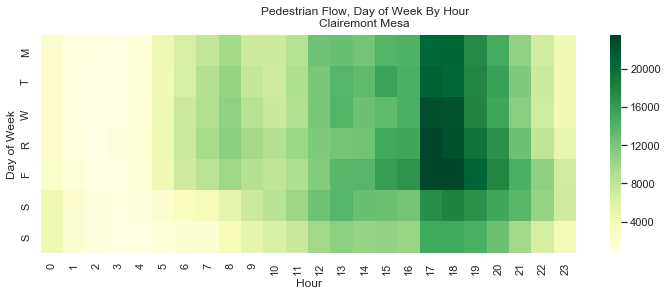

In [5]:
    
ped_heatmap(dfm, 'Clairemont Mesa')

Mission Beach shows a different pattern, with more of the traffic on the weekend, or on Thursday. 

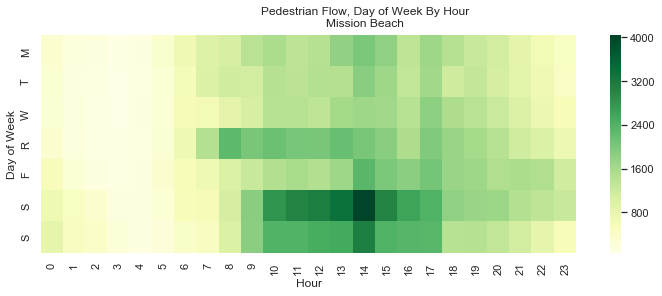

In [6]:
ped_heatmap(dfm, 'Mission Beach')

But the military facilities show a very different pattern, with nearly all activity in the early morning or evening. 

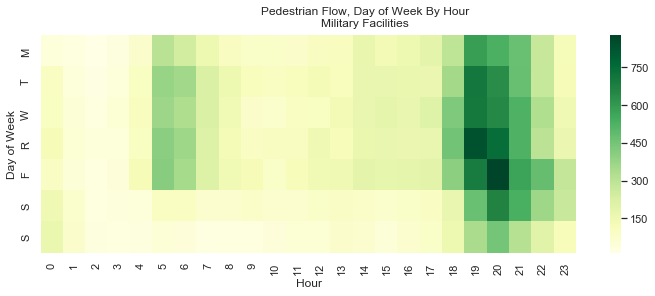

In [7]:
ped_heatmap(dfm, 'Military Facilities')

The Downtown area is one of the most intersting, because it has  a lot of workers during the day, and a lot of residents, and the most active entertainment areas. All of these patterns can be seen in it's rhythm map: a strong weekday noon line for workers going to lunch, an increase on Fridays and Saturday evenings and generally high traffic all of the time. 

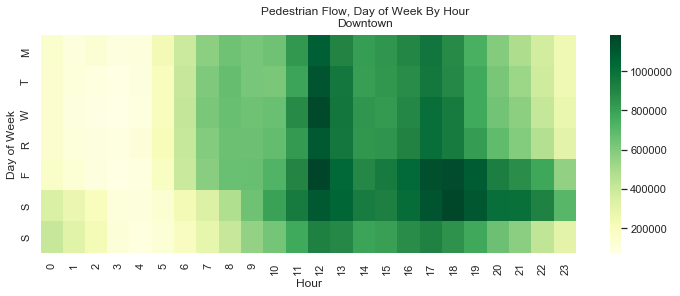

In [8]:
ped_heatmap(dfm, 'Downtown')

# Date versus Hour

Here is a longer term view, for Pacific Beach, showing traffic by hour for each week of the data. It shows that in Pacfici Beach at least, there is little seasonal variation in traffic patterns. 


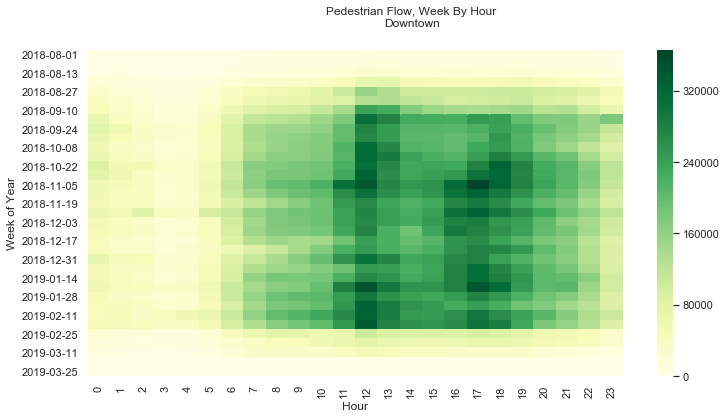

In [10]:

weekly_hour_map(dfm, 'Downtown')

In [11]:
#weekly_week_map(dfm, 'Pacific Beach')

# Line Plots
It's a bit hard to tell the relative values of the colors, so here are some of the communities expressed in line charts, with traffic per hour over the whole dataset. The differentce in morning to evening traffic can be a factor of 3 to 6. 

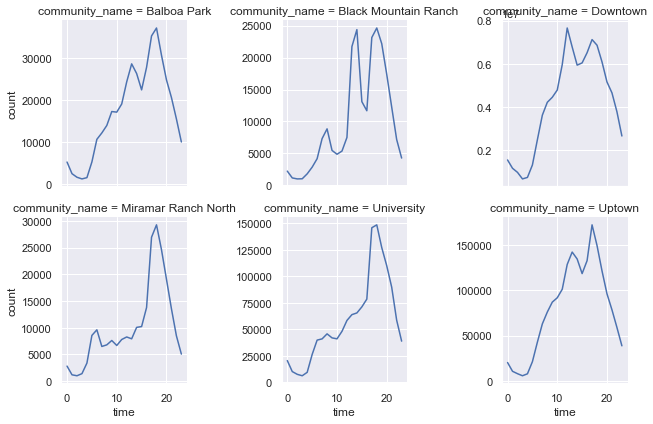

In [12]:
communities = ['Balboa Park','Black Mountain Ranch', 'Downtown','Miramar Ranch North','Uptown','University']

t = dfm.groupby( [dfm.time.dt.hour,'community_name']).sum().reset_index().copy()
t = t[t.community_name.isin(communities)][['time','community_name','count']]
t['community_name'] = t['community_name'].cat.remove_unused_categories()
g = sns.FacetGrid(t, col="community_name", col_wrap=3, sharey=False)
g.map(plt.plot, "time",'count');